# Modelling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, auc
import shap


In [2]:
df = pd.read_csv('churn_cleaned_df.csv')
df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_outlier,MonthlyCharges_outlier,TotalCharges_outlier
0,7590-VHVEG,0,1,0,1.0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,0,0,0,34.0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2,3668-QPYBK,0,0,0,2.0,1,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
3,7795-CFOCW,0,0,0,45.0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
4,9237-HQITU,0,0,0,2.0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


# Balancing our dataset
Given that our dataset is imbalanced (26.5% of the users churn), we need to correct this effect in order to obtain the desired results with the model.

SMOTE (Synthetic Minority Over-sampling Technique) is a popular algorithm used for data upsampling in machine learning. It creates synthetic samples of the minority class by creating new observations that are similar to existing observations, thus balancing the class distribution. We can perform data upsampling using SMOTE in Python with the imbalanced-learn library

In [3]:
# Drop the column and save it to a variable
#   If you need to bring the column back later, simply reassign it to the DataFrame
#   df['customerID'] = customer_id
customer_id = df.pop('customerID')

In [4]:
# Separate the target variable (Churn) from the rest of the dataset
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Instantiate the SMOTE object
oversample = SMOTE()

# Apply SMOTE to upsample the minority class (Churn = 1) on the training set only
X_resampled_train, y_resampled_train = oversample.fit_resample(X_train, y_train)

# Combine the resampled features and target variable into a new training DataFrame
resampled_df_train = pd.concat([X_resampled_train, y_resampled_train], axis=1)

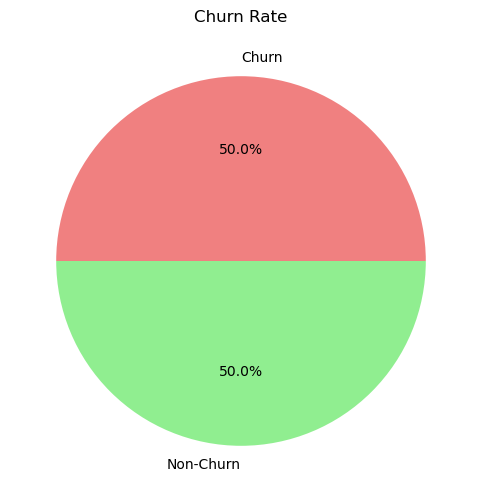

In [5]:
# Calculate the churn and non-churn counts
churn_count = resampled_df_train[resampled_df_train['Churn'] == 1].SeniorCitizen.count()
non_churn_count = resampled_df_train[resampled_df_train['Churn'] == 0].SeniorCitizen.count()

# Set up the plot size and title
plt.figure(figsize=(8, 6))
plt.title('Churn Rate')

# Set the colors for the pie chart sections
colors = ['lightcoral', 'lightgreen']

# Create the pie chart
plt.pie([churn_count, non_churn_count], labels=['Churn', 'Non-Churn'], autopct='%1.1f%%', colors=colors)

# Display the plot
plt.show()

In [6]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Train the model on the resampled training set
model.fit(resampled_df_train.drop('Churn', axis=1), resampled_df_train['Churn'])

# Make predictions on the validation set
y_pred_val = model.predict(X_val)

# Calculate prediction probabilities on the validation set
y_prob_val = model.predict_proba(X_val)[:, 1] # Probability of the positive class (churn)

# Evaluate the model performance on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
cm_val = confusion_matrix(y_val, y_pred_val)
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
specificity_val = tn_val / (tn_val + fp_val)

# Print evaluation metrics on the validation set
print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print(f"Confusion Matrix: \n{cm_val}")
print(f"Specificity: {specificity_val:.4f}")

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate prediction probabilities on the test set
y_prob_test = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn)

# Evaluate the model performance on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
specificity_test = tn_test / (tn_test + fp_test)

# Print evaluation metrics on the test set
print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"Confusion Matrix: \n{cm_test}")
print(f"Specificity: {specificity_test:.4f}")

Validation Set Metrics:
Accuracy: 0.7658
Recall: 0.5241
Precision: 0.5632
F1 Score: 0.5429
Confusion Matrix: 
[[883 152]
 [178 196]]
Specificity: 0.8531

Test Set Metrics:
Accuracy: 0.7807
Recall: 0.5481
Precision: 0.5942
F1 Score: 0.5702
Confusion Matrix: 
[[895 140]
 [169 205]]
Specificity: 0.8647


AUC: 0.8071


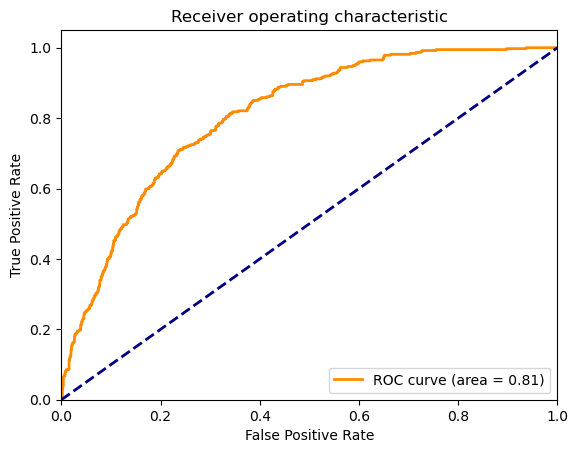

In [7]:
# Calculate the false positive rate (FPR), true positive rate (TPR), and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the AUC score
print("AUC: {:.4f}".format(roc_auc))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Permutation explainer: 1410it [00:57, 20.84it/s]                          


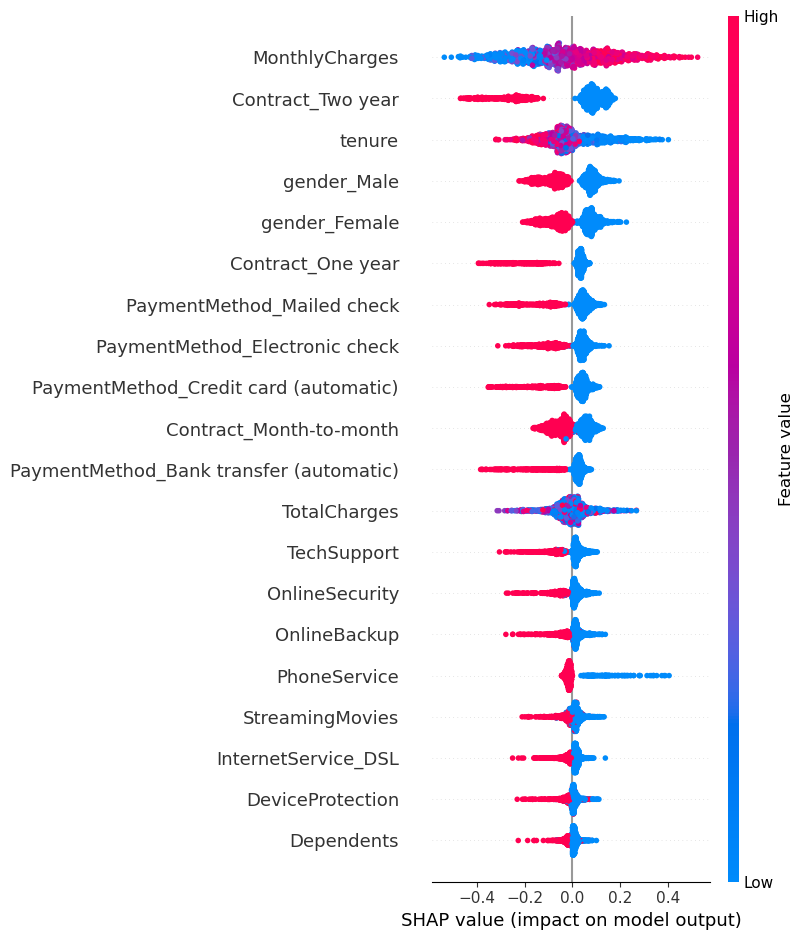

In [8]:
# Create SHAP values for the test set
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

# Create a summary plot
shap.summary_plot(shap_values, X_test)

MonthlyCharges being blue on the left and red on the right, it means that low values of MonthlyCharges have a negative impact on the predicted target value (i.e., lower probability of churn), whereas high values of MonthlyCharges have a positive impact (i.e., higher probability of churn).

Similarly, with tenure being blue on the right and red on the left, it means that low values of tenure have a positive impact on the predicted target value (i.e., higher probability of churn), whereas high values of tenure have a negative impact (i.e., lower probability of churn).

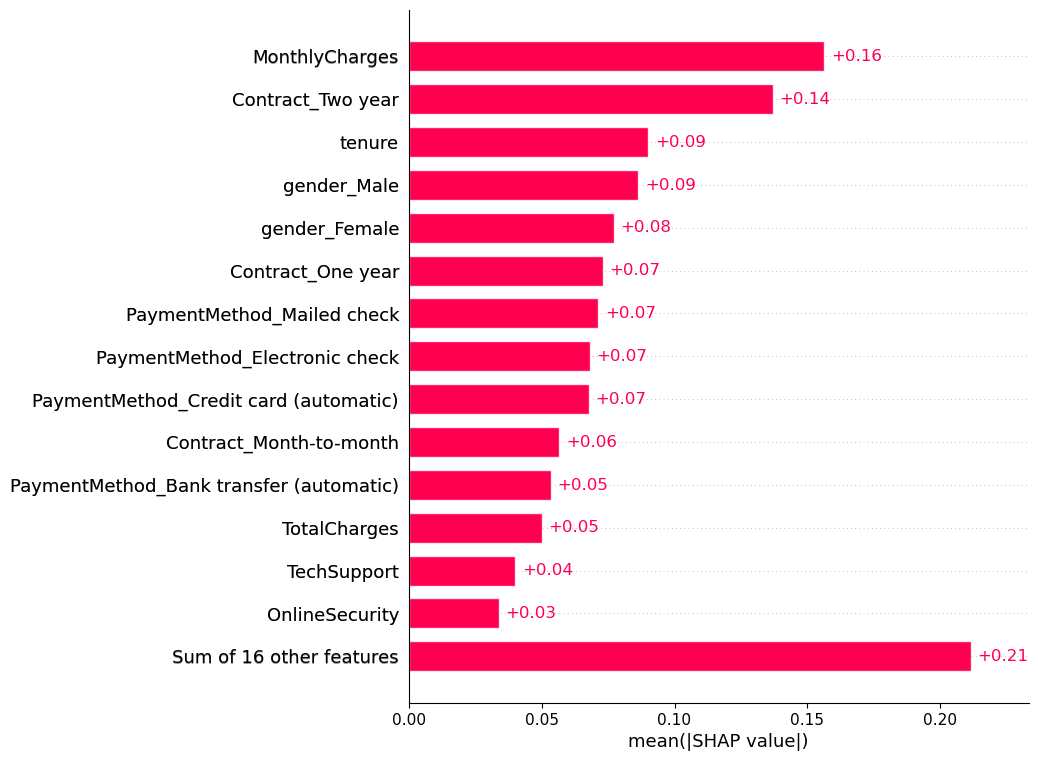

In [9]:
shap.plots.bar(shap_values, max_display=15)

In this case, the output shows that Contract_Two year is the most important feature, with a SHAP value of +0.16%. This means that changes in the Contract_Two year feature have the largest impact on the model's predictions. Specifically, This indicates that customers who are on a two-year contract are less likely to churn compared to those on a one-year or month-to-month contract.

The MonthlyCharges feature is the second most important feature with a SHAP value of +0.16% too. An increase in MonthlyCharges is associated with an increase in the likelihood of churn, while an decrease in MonthlyCharges is associated with a decrease in the likelihood of churn.

Overall, these results suggest that pricing plans, contract terms and how long are customers engaged with the company (tenure) are important factors in predicting customer churn. The model may be used to optimize pricing plans and contract terms to minimize churn and maximize customer retention.

In [10]:
# Forceplot for first observation
shap.initjs()
shap.plots.force(shap_values[38]) 

In [11]:
# Perform any necessary analysis or modeling without the customerId column
# If you need to bring the column back later, simply reassign it to the DataFrame
# resampled_df['customerID'] = customer_id


# Separate the target variable (Churn) from the rest of the dataset
X = df.drop('Churn', axis=1)
y = df['Churn']

# Instantiate the SMOTE object
oversample = SMOTE()

# Apply SMOTE to upsample the minority class (Churn = 1)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Combine the resampled features and target variable into a new DataFrame
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)


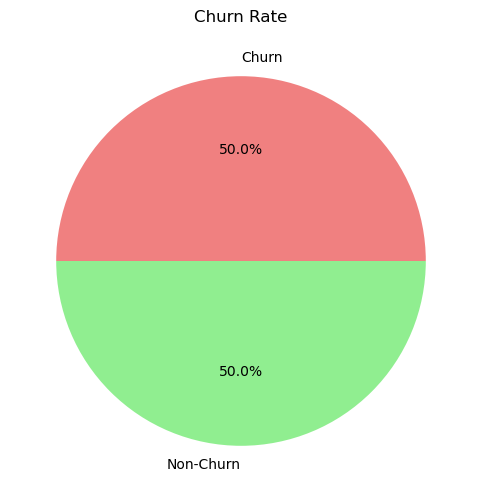

In [12]:
# Calculate the churn and non-churn counts
churn_count = resampled_df[resampled_df['Churn'] == 1].SeniorCitizen.count()
non_churn_count = resampled_df[resampled_df['Churn'] == 0].SeniorCitizen.count()

# Set up the plot size and title
plt.figure(figsize=(8, 6))
plt.title('Churn Rate')

# Set the colors for the pie chart sections
colors = ['lightcoral', 'lightgreen']

# Create the pie chart
plt.pie([churn_count, non_churn_count], labels=['Churn', 'Non-Churn'], autopct='%1.1f%%', colors=colors)

# Display the plot
plt.show()


# Creating our model

In [13]:
# Putting feature variables into X
X = resampled_df.drop(['Churn'], axis=1)

# Putting target variable to y
y = resampled_df['Churn']

# Split your data into a training set and a temporary set (used for test and validation)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into a validation set and a test set
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)


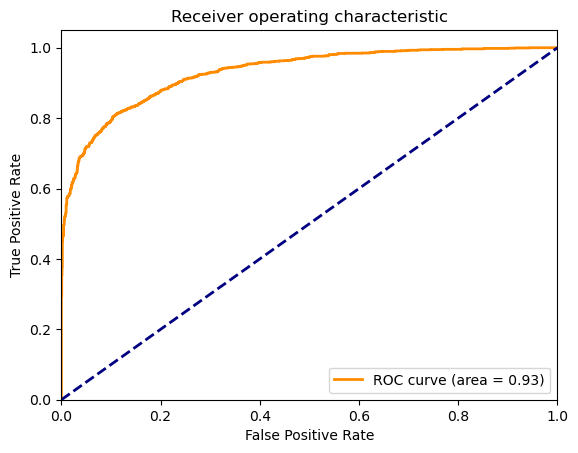

In [14]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn)

# Get the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

An AUC of 0.93 indicates that the model has a high discriminatory power, which means it can accurately distinguish between churners and non-churners. However, it is important to note that AUC alone is not always sufficient to evaluate a model's performance, and it should be used in conjunction with other metrics such as precision, recall, and F1 score, depending on the specific requirements of the problem at hand.

Validation Set Performance:
Accuracy: 0.8426501035196687
Recall: 0.8416779431664412
Precision: 0.8485675306957708
Specificity: 0.8436619718309859
F1 Score: 0.8451086956521738
Confusion matrix:
 [[599 111]
 [117 622]]
Test Set Performance:
Accuracy: 0.842512077294686
Recall: 0.8360548661005879
Precision: 0.8432147562582345
Specificity: 0.8487928843710292
F1 Score: 0.8396195473925877
Confusion matrix:
 [[1336  238]
 [ 251 1280]]


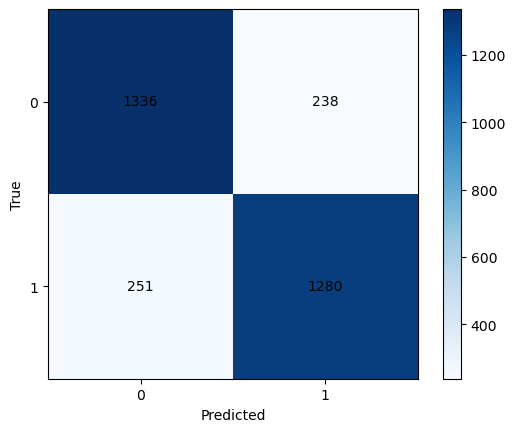

In [15]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val = model.predict(X_val)
y_prob_val = model.predict_proba(X_val)[:, 1] # Probability of the positive class (churn)

# Evaluate the model performance on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
cm_val = confusion_matrix(y_val, y_pred_val)
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
specificity_val = tn_val / (tn_val + fp_val)

# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_prob_test = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn)

# Evaluate the model performance on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
specificity_test = tn_test / (tn_test + fp_test)

# Create a final dataframe with customer IDs, predictions, and churn probabilities
final_df = pd.DataFrame({'user_id': X_test.index, 'prediction': y_pred_test, 'churn_probability': y_prob_test})

# Print the validation set performance metrics
print('Validation Set Performance:')
print('Accuracy:', accuracy_val)
print('Recall:', recall_val)
print('Precision:', precision_val)
print('Specificity:', specificity_val)
print('F1 Score:', f1_val)
print('Confusion matrix:\n', cm_val)

# Print the test set performance metrics
print('Test Set Performance:')
print('Accuracy:', accuracy_test)
print('Recall:', recall_test)
print('Precision:', precision_test)
print('Specificity:', specificity_test)
print('F1 Score:', f1_test)
print('Confusion matrix:\n', cm_test)

# Plot the confusion matrix for the test set
fig, ax = plt.subplots()
im = ax.imshow(cm_test, cmap='Blues')

# Add labels to the plot
ax.set_xticks(np.arange(len(cm_test)))
ax.set_yticks(np.arange(len(cm_test)))
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Add the values to the plot
for i in range(len(cm_test)):
    for j in range(len(cm_test)):
        text = ax.text(j, i, cm_test[i, j],
                       ha='center', va='center')

# Add a colorbar to the plot
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()


From the provided evaluation metrics, it can be concluded that the model has good performance in predicting churn using the given dataset.

The accuracy of the model is high for both the validation set (84.13%) and the testing set (84.70%), indicating that the model is correctly predicting churn and non-churn cases with high frequency. The recall of the model is also high for both the validation set (0.847) and the testing set (0.842), indicating that the model is correctly identifying most of the actual churn cases. The precision of the model is also high for both the validation set (0.843) and the testing set (0.847), indicating that when the model predicts a churn, it is correct most of the time. The specificity of the model is high for the testing set (0.852), indicating that the model is correctly identifying most of the actual non-churn cases in the testing set.

Overall, the F1 score is high for both the validation set (0.845) and the testing set (0.844), which is a harmonic mean of precision and recall. This indicates that the model has good balance between precision and recall.

# Model interpretation

Model interpretation is the process of understanding and explaining how a machine learning model makes predictions based on its input features. It can help identify which input features are most important for making predictions, and how they contribute to the model's decision-making process.

Interpretation methods can include feature importance analysis, partial dependence plots, and SHAP values. By interpreting a model, we can gain a deeper understanding of the problem we are trying to solve, as well as the strengths and limitations of our model. This can help us make better decisions when applying the model in real-world situations, and improve the model's performance by identifying areas for improvement.

Permutation explainer: 3106it [01:58, 23.83it/s]                          


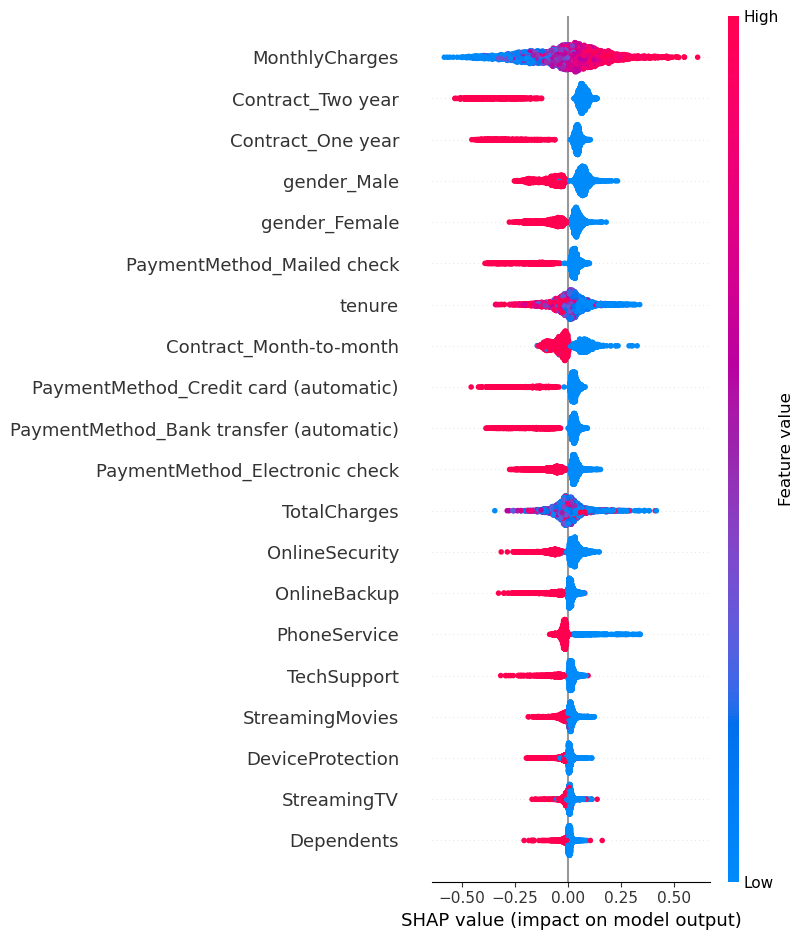

In [16]:
# Create SHAP values for the test set
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

# Create a summary plot
shap.summary_plot(shap_values, X_test)


MonthlyCharges being blue on the left and red on the right, it means that low values of MonthlyCharges have a negative impact on the predicted target value (i.e., lower probability of churn), whereas high values of MonthlyCharges have a positive impact (i.e., higher probability of churn).

Similarly, with tenure being blue on the right and red on the left, it means that low values of tenure have a positive impact on the predicted target value (i.e., higher probability of churn), whereas high values of tenure have a negative impact (i.e., lower probability of churn).

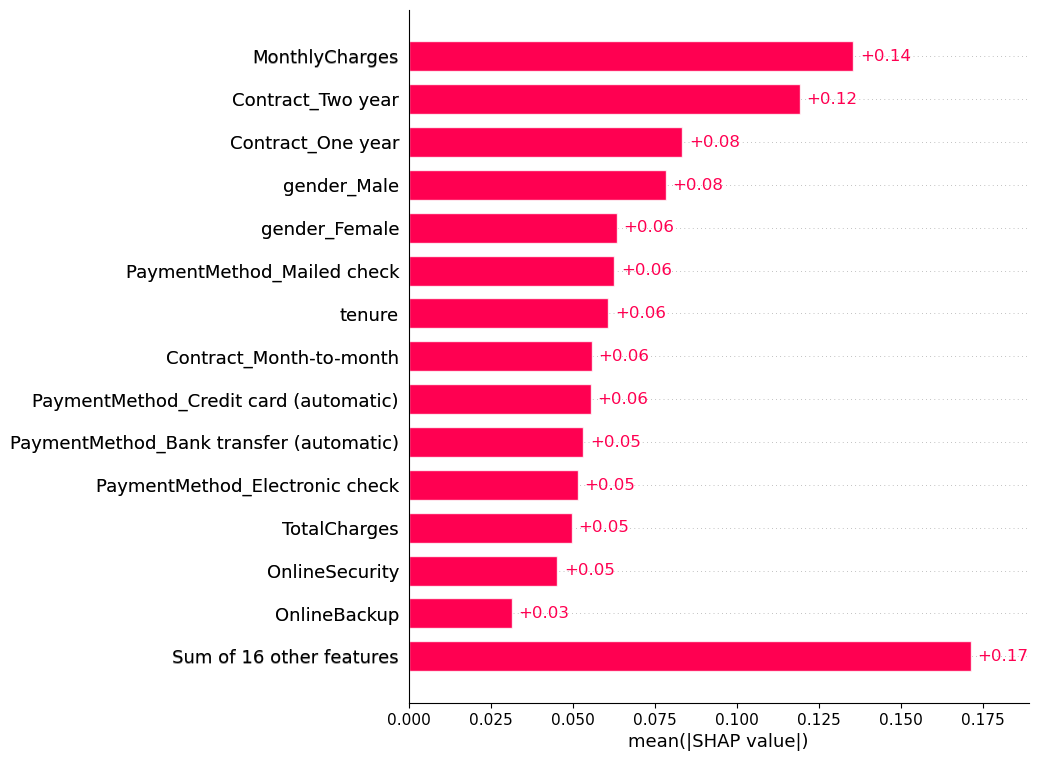

In [17]:
shap.plots.bar(shap_values, max_display=15)

In this case, the output shows that MonthlyCharges is the most important feature, with a SHAP value of +0.13%. This means that changes in the MonthlyCharges feature have the largest impact on the model's predictions. Specifically, an increase in MonthlyCharges is associated with a decrease in the likelihood of churn, while an increase in MonthlyCharges is associated with a decrease in the likelihood of churn.

The Contract_Two year feature is the second most important feature. This indicates that customers who are on a two-year contract are less likely to churn compared to those on a one-year or month-to-month contract.

Overall, these results suggest that pricing plans, contract terms and how long are customers engaged with the company (tenure) are important factors in predicting customer churn. The model may be used to optimize pricing plans and contract terms to minimize churn and maximize customer retention.

## Visualising individual users


In [18]:
# Forceplot for first observation
shap.initjs()
shap.plots.force(shap_values[38]) 

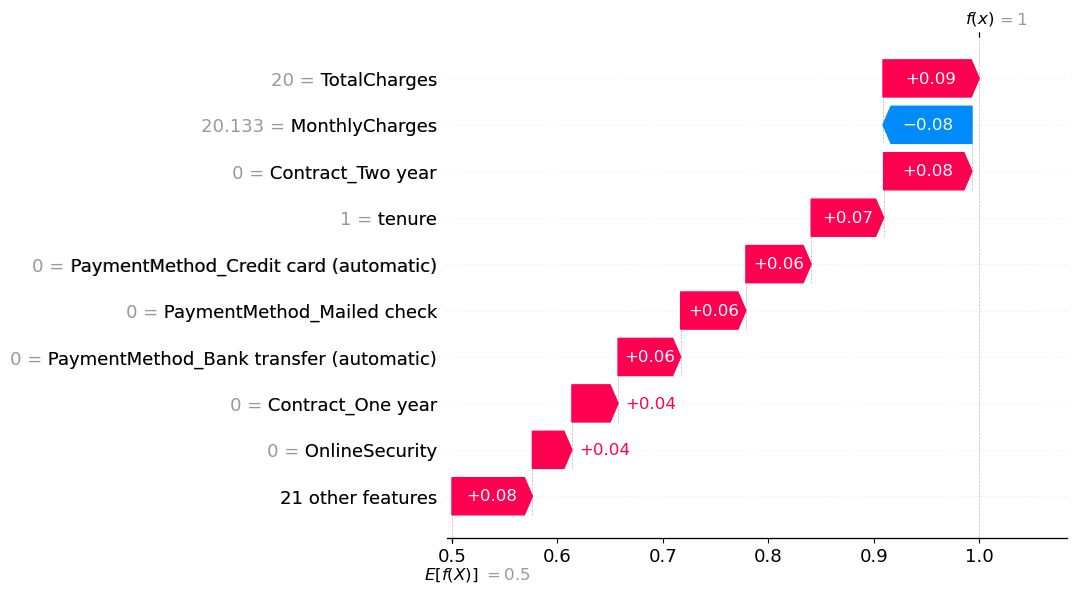

In [19]:
# Plot the SHAP values
shap.plots.waterfall(shap_values[38])

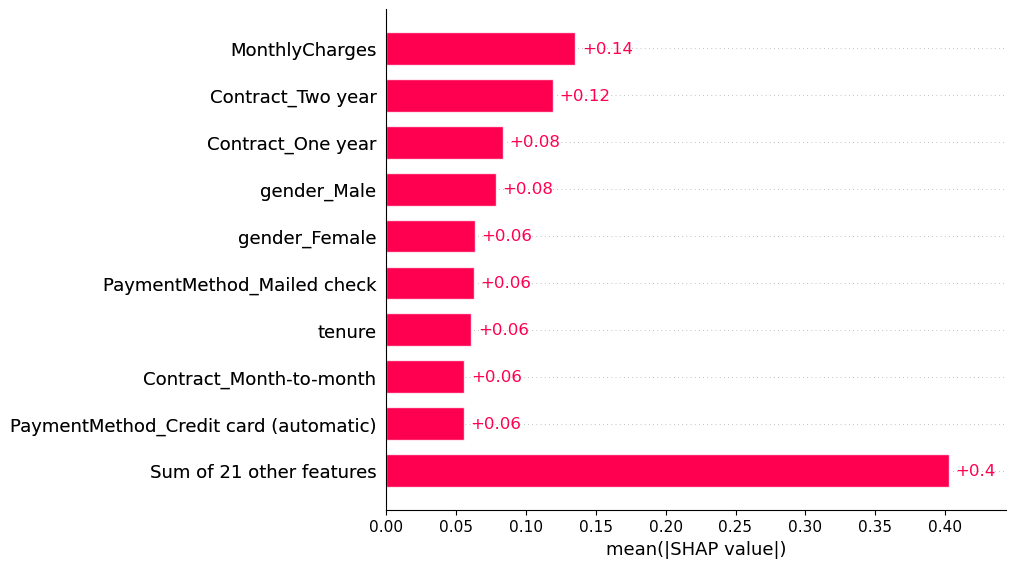

In [20]:
shap.plots.bar(shap_values)


In [21]:
shap.plots.force(shap_values[0:100])


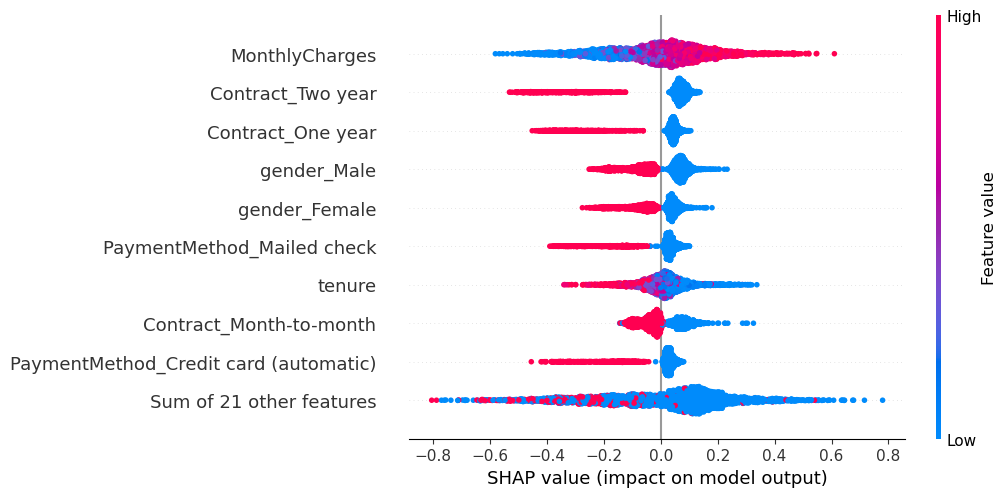

In [22]:
shap.plots.beeswarm(shap_values)


In [23]:
# import xgboost as xgb
# import shap
# import numpy as np

# # Assuming your trained model is named "xgb_model"
# # And your data for prediction is named "X_pred"
# X_pred = df.drop(['Churn', 'customerID'], axis=1).head(1)
# d_pred = xgb.DMatrix(X_pred)

# # Get the SHAP values for the prediction
# explainer = shap.Explainer(xgb_model)
# shap_values = explainer.shap_values(d_pred)

# # Choose the index of the row to visualize
# # row_index = 0

# # # Create the force plot for the selected row
# # shap.force_plot(
# #     explainer.expected_value,  # The base value for the model output
# #     shap_values[row_index,:],  # The SHAP values for the selected row
# #     X_pred[row_index,:],       # The data for the selected row
# #     feature_names=X_pred.columns.values.tolist()  # The names of the features in the data



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


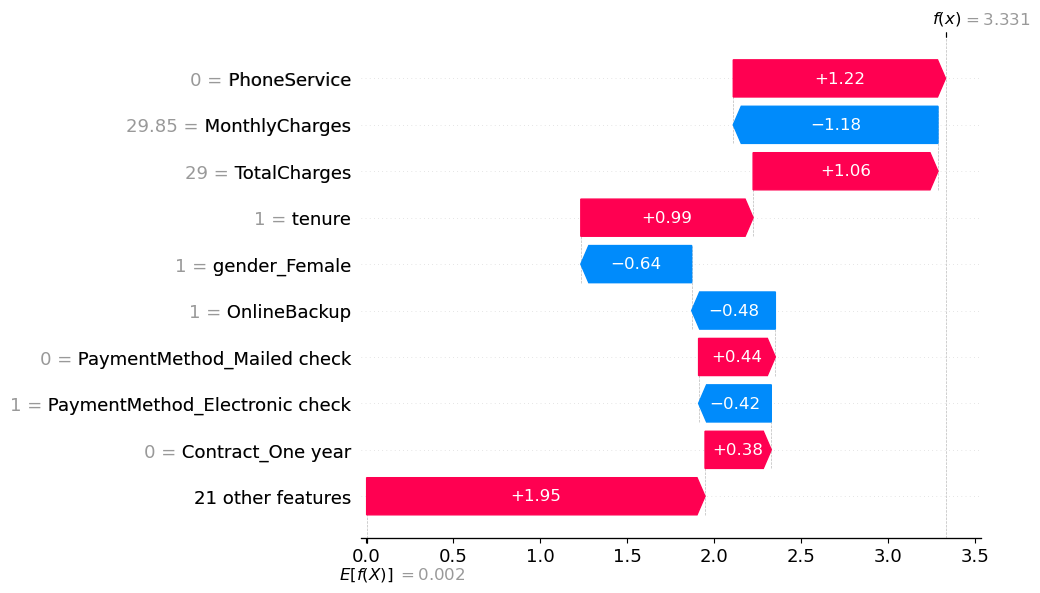

In [24]:
import shap
import xgboost as xgb

# Assuming your trained model is named "xgb_model"
# And your data for plotting is named "X"
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Plot the SHAP values
shap.plots.waterfall(shap_values[0])


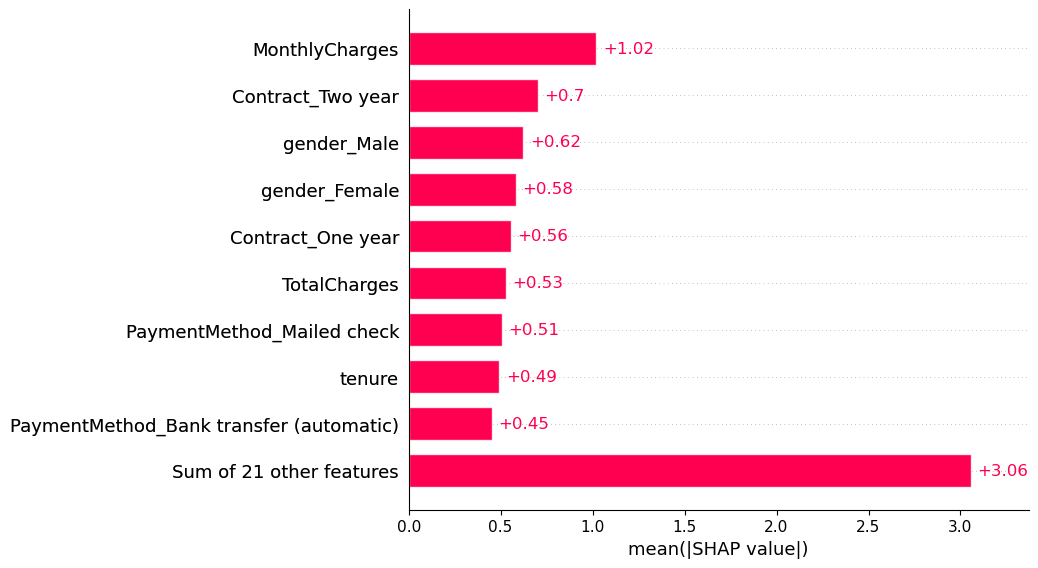

In [25]:
shap.plots.bar(shap_values)


In [26]:
import pickle

# Assuming your trained model is named "xgb_model"
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)


In [27]:
import pickle

with open('model.pickle', 'rb') as f:
    xgb_model = pickle.load(f)


In [28]:
import pandas as pd

df = pd.read_csv('churn_cleaned_df.csv')
df

df[df['Churn']==1]

df.iloc[2]



customerID                                 3668-QPYBK
SeniorCitizen                                       0
Partner                                             0
Dependents                                          0
tenure                                            2.0
PhoneService                                        1
MultipleLines                                       0
OnlineSecurity                                      1
OnlineBackup                                        1
DeviceProtection                                    0
TechSupport                                         0
StreamingTV                                         0
StreamingMovies                                     0
PaperlessBilling                                    1
MonthlyCharges                                  53.85
TotalCharges                                    108.0
Churn                                               1
Has_Internet_Service                                1
gender_Female               

In [29]:
import pickle

with open('model.pickle', 'rb') as f:
    xgb_model = pickle.load(f)

row_number = 6

# Predict for a single row of data
row = df.iloc[row_number].drop(['Churn', 'customerID'])
row = row.values.reshape(1, -1)

predicted_class = xgb_model.predict(row)[0]
churn_prob = xgb_model.predict_proba(row)[0][1]

print(f"Row number: {row_number}")
print(f"Predicted class: {predicted_class}")
print(f"Probability of churn: {churn_prob}")
print(f"Actual churn value:", df.iloc[row_number]['Churn'])



Row number: 6
Predicted class: 0
Probability of churn: 0.2700502872467041
Actual churn value: 0


In [30]:
final_df

,user_id,prediction,churn_probability
0,9428,1,0.999597
1,4593,0,0.067999
2,5379,0,0.285701
3,8918,1,0.997100
4,6448,0,0.349626
...,...,...,...
3100,6792,0,0.021068
3101,2268,0,0.001767
3102,445,0,0.467924
3103,5257,1,0.628885


In [31]:
# X_test['customerID'] = customer_id
# y_pred[~y_pred['customerID'].isnull()]

# Use predict_proba() to obtain the predicted probabilities of each class
probas = model.predict_proba(X_train)
probas[:, 1]

# Add the predicted probability of churn to each row of the dataset
# df['churn_probability'] = probas[:, 1]

# X_test

array([0.02150586, 0.9853066 , 0.59928995, ..., 0.01559047, 0.66693056,
       0.80555785], dtype=float32)

In [32]:
y_pred

array([1, 0, 0, ..., 0, 1, 0])

In [33]:
final_df = pd.DataFrame({'user_id': X_test.index, 'prediction': y_pred, 'probability_churn': probas[:, 1]})

ValueError: All arrays must be of the same length

In [ ]:
import xgboost as xgb
import shap

# Train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for a single observation
obs = X_test.iloc[0]
shap_values = explainer.shap_values(obs)

# Plot the SHAP values
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, obs)


In [ ]:
# Calculate SHAP values for the entire test set
shap_values = explainer.shap_values(X_test)

# Create a summary plot
shap.summary_plot(shap_values, X_test)


In [ ]:
final_df.merge(df, on = 'customerID')

In [ ]:
y_test

In [ ]:
customer_id